In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/msc')
os.getcwd()

'/content/drive/MyDrive/msc'

In [4]:
import pandas as pd
import numpy as np

In [5]:
tcs=pd.read_csv('tcs_expsetup2.csv')
data = tcs.filter(['FibonacciLevels'])

dataset =data.values

training_data_len = int(np.ceil(len(dataset)*0.95))


In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler_tcs=MinMaxScaler(feature_range=(0,1))
scaled_data = scaler_tcs.fit_transform(dataset)


In [8]:

 # Creating XY_splits
train_data = scaled_data[0:int(training_data_len),:]
X_train=[]
y_train=[]

for i in range(60,len(train_data)):
  X_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

#  if i<=61:
#    print(X_train,y_train)

X_train,y_train = np.array(X_train),np.array(y_train)

X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

In [9]:

import tensorflow as tf
opt_lr=1e-4

In [10]:

# Building  model

#Setting random seed
tf.random.set_seed(42)

# model
model_lstm_tcs = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],1)),
      tf.keras.layers.LSTM(60,return_sequences=True),
	  tf.keras.layers.LSTM(60),
      tf.keras.layers.Dense(1)
])

# Compile model
model_lstm_tcs.compile(loss=tf.keras.losses.mae,
                   optimizer=tf.keras.optimizers.Adam(learning_rate=opt_lr),
                   metrics='mae')

# Train the model
model_lstm_tcs.fit(X_train,y_train,epochs=40,verbose=0)

In [11]:

 # Creating XY_splits
test_data = scaled_data[int(training_data_len)-60:,:]
X_test=[]
y_test=dataset[training_data_len:,:]

for i in range(60,len(test_data)):
  X_test.append(test_data[i-60:i,0])

X_test=np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [12]:
y_pred_test = model_lstm_tcs.predict(X_test)
y_pred_test_real = scaler_tcs.inverse_transform(y_pred_test)

In [13]:
import matplotlib.pyplot as plt

<Figure size 720x576 with 0 Axes>

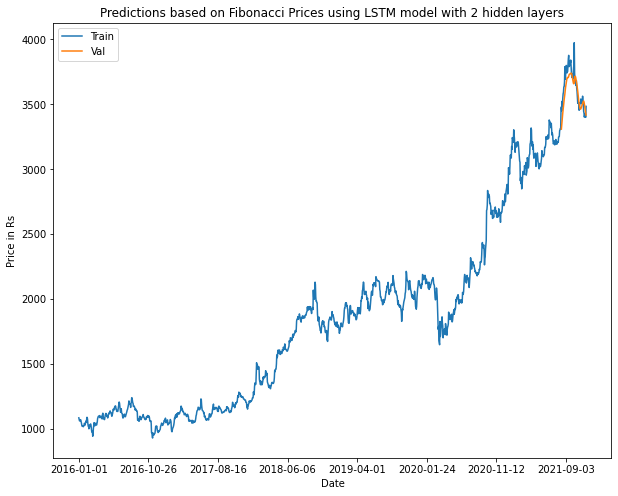

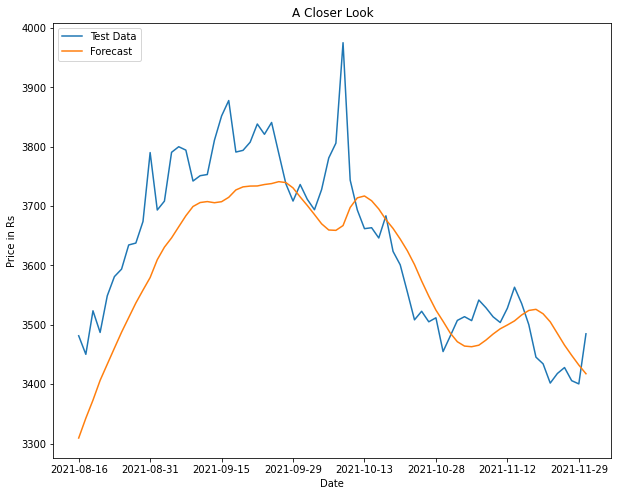

In [14]:

datadf = tcs.filter(['Date','FibonacciLevels'])

# Plot the data
train = datadf[:training_data_len]
valid = datadf[training_data_len:]
train = train.set_index('Date')
valid = valid.set_index('Date')

valid['Predictions'] = y_pred_test_real
finaldf = pd.concat([train,valid],axis=0)
# Visualize the data
plt.figure(figsize=(10,8))
finaldf[['FibonacciLevels','Predictions']].plot(figsize=(10,8))
plt.title('Predictions based on Fibonacci Prices using LSTM model with 2 hidden layers')
plt.xlabel('Date')
plt.ylabel('Price in Rs')
plt.legend(['Train','Val','Predictions'],loc='upper left')

valid[['FibonacciLevels','Predictions']].plot(figsize=(10,8))
plt.xlabel('Date')
plt.title('A Closer Look')
plt.ylabel('Price in Rs')
plt.legend(['Test Data','Forecast'],loc='upper left')